In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb
from data_manipulation.reading_util import H5ESM2

import torch
from torch.utils.data import Dataset



2023-09-12 15:17:45.781533: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 15:17:45.944419: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 15:17:45.945660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 15:17:47.214424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
enzyme_csv_path = os.getenv("CSV70_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_70")

non_esm2_enzymes_path = os.getenv("ESM2_NON_ENZYMES")


X, y = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)

print(len(y))
print(len(X))


h5_esm2 = H5ESM2(non_esm2_enzymes_path)

loader = torch.utils.data.DataLoader(h5_esm2, batch_size=32, shuffle=True)

# Iterate over batches
X_n = []

t0 = time.time()

for batch in loader:
    emb, _ = batch
    X_n.append(emb.numpy())

t1 = time.time()

# Convert the lists to numpy arrays
X_n = np.vstack(X_n)

y_n = [7 for emb in range(len(X_n))] # adding labels for non enzymes:
                                     # (0-6 → enzyme; 7 → non_enzyme)
y_n = np.array(y_n)
total = (t1-t0)/60
print(f"Non Enzymes data loaded in: {round(total, 3)} min")

print(len(X_n))
print(len(y_n))

Data loaded in: 8.561 min
73553
73553
Non Enzymes data loaded in: 4.538 min
39502
39502


In [3]:
X = np.vstack((X, X_n))
y = np.hstack((y, y_n))

In [4]:
print(len(X))
print(len(y))

# Control
print(X[0]) # should be an enzyme
print(y[0])

print(X[-1]) # shouldn't be an enzyme
print(y[-1])

113055
113055
[-0.08300029  0.01820193  0.04713448 ...  0.02561503 -0.19785273
 -0.03933959]
2
[ 0.04190568 -0.00531857 -0.05199047 ...  0.03388118 -0.1008556
  0.04040164]
7


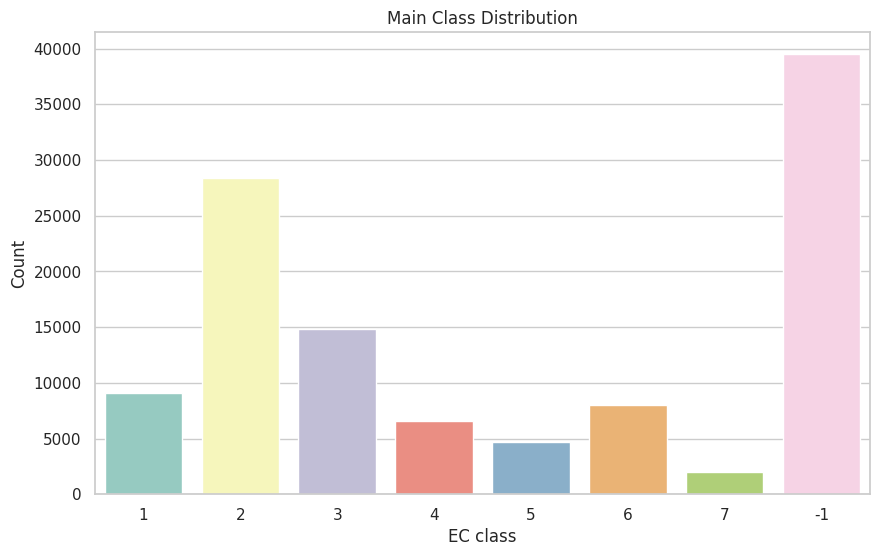

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, -1])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Main Class Distribution")

# Show the plot
plt.show()


# Splitting data

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=8)
print(y_test_encoded[0])


[0. 0. 1. 0. 0. 0. 0. 0.]


# Creating CNN

In [7]:
earl_stop = tf.keras.callbacks.EarlyStopping(patience=10)

In [8]:
# Initializing the model
model = tf.keras.models.Sequential()

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training CNN

In [9]:
model.fit(x=X_train, y=y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/50


2023-09-12 15:32:01.515004: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 810373120 exceeds 10% of free system memory.


2474/2474 [==============================] - 29s 11ms/step - loss: 0.7167 - val_loss: 0.3189
Epoch 2/50
2474/2474 [==============================] - 28s 11ms/step - loss: 0.3986 - val_loss: 0.2527
Epoch 3/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.3302 - val_loss: 0.2125
Epoch 4/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.2958 - val_loss: 0.2046
Epoch 5/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.2724 - val_loss: 0.1865
Epoch 6/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.2504 - val_loss: 0.1798
Epoch 7/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.2401 - val_loss: 0.1740
Epoch 8/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.2300 - val_loss: 0.1636
Epoch 9/50
2474/2474 [==============================] - 27s 11ms/step - loss: 0.2169 - val_loss: 0.1621
Epoch 10/50
2474/2474 [==============================] - 27s 11ms/step - lo

# Evaluation

<Figure size 1000x600 with 0 Axes>

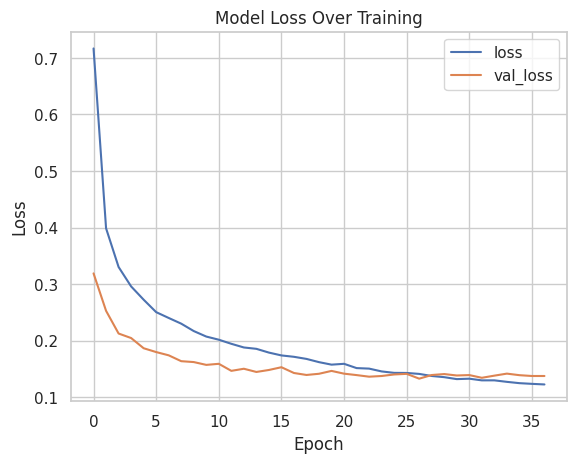

In [10]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
# for multi class classification (using softmax)
predictions = np.argmax(model.predict(X_test), axis=-1) 

1060/1060 [==============================] - 2s 2ms/step


In [12]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  32707
Total samples predicted: 33917


In [13]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2718
           1       0.97      0.98      0.97      8681
           2       0.95      0.96      0.96      4459
           3       0.95      0.96      0.96      1993
           4       0.98      0.95      0.96      1396
           5       0.99      0.99      0.99      2405
           6       0.96      0.94      0.95       570
           7       0.96      0.95      0.96     11695

    accuracy                           0.96     33917
   macro avg       0.97      0.96      0.96     33917
weighted avg       0.96      0.96      0.96     33917


In [14]:
def plot_report(report, y , predictions):
    """
    Plots results of model
    :param report: Report of model
    """

    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]
    class_2_metrics = report.split('\n')[4].split()[1:]
    class_3_metrics = report.split('\n')[5].split()[1:]
    class_4_metrics = report.split('\n')[6].split()[1:]
    class_5_metrics = report.split('\n')[7].split()[1:]
    class_6_metrics = report.split('\n')[8].split()[1:]
    class_7_metrics = report.split('\n')[9].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               class_2_metrics,
               class_3_metrics,
               class_4_metrics,
               class_5_metrics,
               class_6_metrics,
               class_6_metrics
               ]

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [1, 2, 3, 4, 5, 6, 7, 0]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Main Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Main Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Main Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

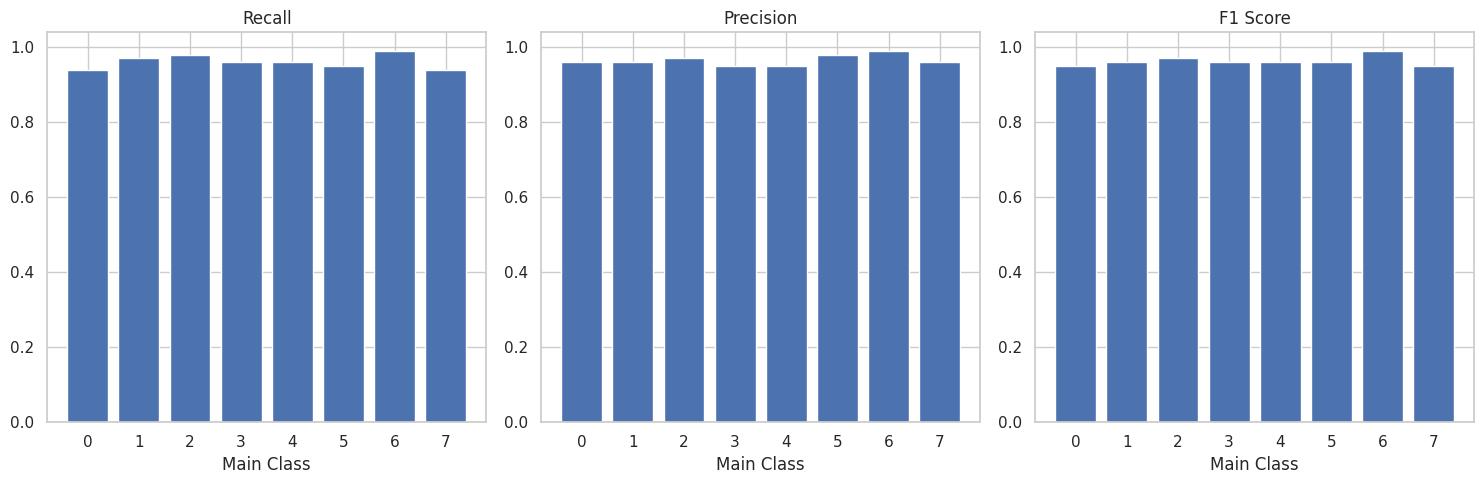

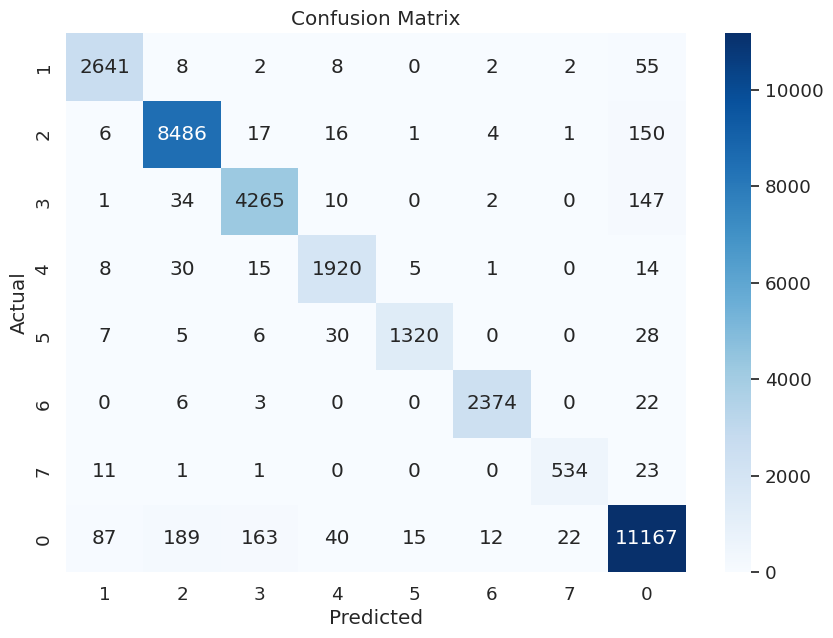

In [15]:
plot_report(report, y_test, predictions)

In [16]:
model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_v1_enz_non_enz_S70.keras")